In [558]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Brute force

In [559]:
# Pauli matrices
σx = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
σy = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
σz = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
σp = (σx + 1j*σy) / 2  # raising
σm = (σx - 1j*σy) / 2  # lowering

def place(op, site, N):
    """
    Place single-site operator `op` at position `site` in an N-site chain.
    op: 2x2 sparse matrix
    site: int, 0-based site index
    N: total number of sites
    """
    mats = []
    for i in range(N):
        mats.append(op if i == site else sp.eye(2, format='csr', dtype=complex))
    # Tensor product
    result = mats[0]
    for m in mats[1:]:
        result = sp.kron(result, m, format='csr')
    return result

# 1) Build spin-ladder Hamiltonian (open boundaries)
def build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q, g_phi_x):
    """
    Build the many-body Hamiltonian for an open spin ladder of L unit cells (2L sites).
    """
    N_sites = 2 * L
    g_qc = np.sqrt(g_q * g_c)
    H = sp.csr_matrix((2**N_sites, 2**N_sites), dtype=complex)
    
    for n in range(L):
        ia = 2*n      # cavity-leg site index
        ib = ia + 1   # qubit-leg site index
        
        # Onsite sigma_z terms
        H += -(omega_c/2) * place(σz, ia, N_sites)
        H += -(omega_q/2) * place(σz, ib, N_sites)
        
            
        # Rung coupling g_Φ: flip-flop between a_n and b_n
        H +=  g_Φ * (place(σp, ib, N_sites) @ place(σm, ia, N_sites) +
                     place(σm, ib, N_sites) @ place(σp, ia, N_sites))
        
        # Only add inter-cell terms if not last cell (open BC)
        if n < L-1:
            ia_next = ia + 2
            ib_next = ib + 2
            # cavity leg hopping +g_c
            H +=  g_c * (place(σp, ia, N_sites) @ place(σm, ia_next, N_sites) +
                         place(σm, ia, N_sites) @ place(σp, ia_next, N_sites))
            # qubit leg hopping -g_q
            H += -g_q * (place(σp, ib, N_sites) @ place(σm, ib_next, N_sites) +
                         place(σm, ib, N_sites) @ place(σp, ib_next, N_sites))
            # diagonals sqrt(g_q g_c)
            H += -g_qc * (place(σp, ib, N_sites) @ place(σm, ia_next, N_sites) +
                          place(σm, ib, N_sites) @ place(σp, ia_next, N_sites))
            H +=  g_qc * (place(σp, ia, N_sites) @ place(σm, ib_next, N_sites) +
                          place(σm, ia, N_sites) @ place(σp, ib_next, N_sites))
    return H


def single_excitation_basis_matrix(N_sites):
    """
    Returns a sparse rectangular matrix U with shape (2**N_sites, N_sites),
    whose columns are computational basis states with exactly one excitation.
    """
    dim_full = 2 ** N_sites
    dim_subspace = N_sites  # single excitation dimension

    data = []
    rows = []
    cols = []

    col_idx = 0
    for idx in range(dim_full):
        state_bin = format(idx, f'0{N_sites}b')
        if state_bin.count('1') == 1:
            rows.append(idx)
            cols.append(col_idx)
            data.append(1.0)
            col_idx += 1

    U = sp.csr_matrix((data, (rows, cols)), shape=(dim_full, dim_subspace), dtype=complex)
    return U

def zero_and_single_excitation_basis(N_sites):
    """
    Return a sparse matrix U whose columns span |0...0> plus all states with
    exactly one '1'.  Dim = N_sites+1, ordered as  |vac>,|100..0>,|010..0>,...
    """
    dim_full = 2 ** N_sites
    dim_sub  = N_sites + 1
    data, rows, cols = [1.0], [0], [0]   # first column = |0...0>

    col_idx = 1
    for idx in range(1, dim_full):          # skip all‑zeros
        if bin(idx).count("1") == 1:
            rows.append(idx)
            cols.append(col_idx)
            data.append(1.0)
            col_idx += 1
    U = sp.csr_matrix((data, (rows, cols)), shape=(dim_full, dim_sub), dtype=complex)
    return U

In [503]:
# Example parameters
omega_c = 5
omega_q = 5.0
g_Φ = 0
g_c = 1
g_q = 1


In [504]:
L = 4
N_sites = 2 * L
# Build and diagonalize
H_spin = build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q)

In [505]:
# Use sparse eigensolver to find lowest few eigenstates
k_eigs = 2**(2*L)-2  # how many eigenvalues
# k_eigs = 1000  # how many eigenvalues
eigvals, eigvecs = spla.eigsh(H_spin, k=k_eigs, which='SA')  # smallest algebraic
# eigvals, eigvecs = np.linalg.eigh(H_spin.toarray())  # smallest algebraic

# Sort eigenvalues
idx = np.argsort(np.real(eigvals))
eigvals = eigvals[idx]
eigvecs = eigvecs[idx]

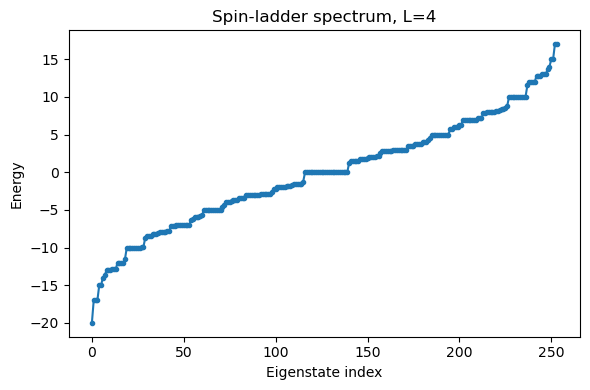

In [506]:
# Plot spectrum
plt.figure(figsize=(6,4))
plt.plot(np.arange(k_eigs), np.real(eigvals), '.-')
plt.xlabel('Eigenstate index')
plt.ylabel('Energy')
plt.title(f'Spin-ladder spectrum, L={L}')
plt.tight_layout()
plt.show()


In [507]:
U1 = single_excitation_basis_matrix(N_sites)
U2 = zero_and_single_excitation_basis(N_sites)
H_single_exc_subspace1 = U1.conj().T @ H_spin @ U1
H_single_exc_subspace2 = U2.conj().T @ H_spin @ U2

In [508]:
E1, ψ1 = np.linalg.eigh(H_single_exc_subspace1.todense())
E2, ψ2 = np.linalg.eigh(H_single_exc_subspace2.todense())

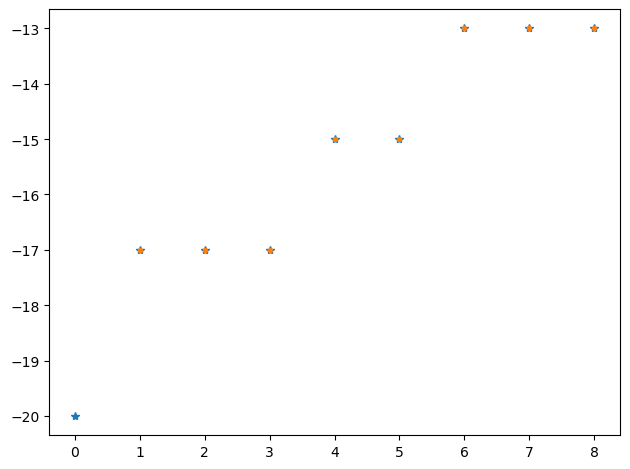

In [509]:
fig, ax = plt.subplots()

ax.plot(np.arange(N_sites+1), E2,'*')
ax.plot(np.arange(N_sites)+1, E1,'.')

fig.tight_layout()

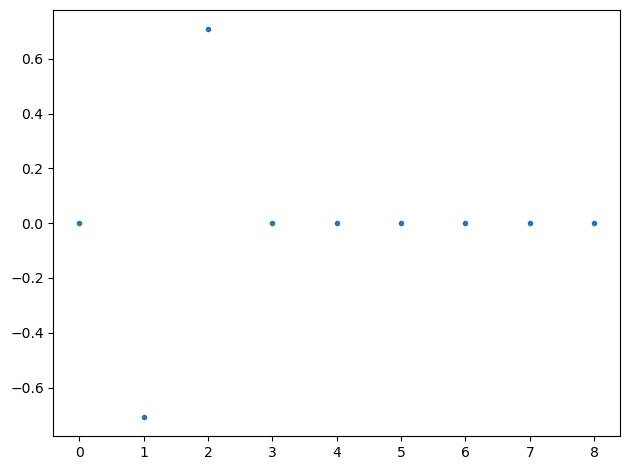

In [510]:
mid_index = 5
eigenvector_of_interest = ψ2[:, mid_index]  # column
fig, ax = plt.subplots()

ax.plot(np.real(eigenvector_of_interest),'.')
# ax.plot(np.imag(eigenvector_of_interest),'.')

fig.tight_layout()

In [511]:



# --------------------------------------------------------------------------------------
# Pauli operators on first / last site  -------------------------------------------------
# --------------------------------------------------------------------------------------
def build_A_B(A, B, N_sites):
    """A = σ^x on site 0,  B = σ^z on site (N_sites‑1)."""
    A_full = place(A, 0,          N_sites)
    B_full = place(B, N_sites-1,  N_sites)
    return A_full, B_full


# --------------------------------------------------------------------------------------
# Kubo susceptibility  χ_{B A}(ω)  ------------------------------------------------------
# --------------------------------------------------------------------------------------
def chi_Kubo(omega, E, evecs, A_sub, B_sub, gamma=1e-2):
    """
    Retarded cross‑susceptibility χ_{BA}(ω) with Lorentzian broadening γ.
    """
    evecs = np.asarray(evecs)    # make sure we have a plain ndarray

    n_sub = E.size
    vac   = np.zeros(n_sub, dtype=complex);  vac[0] = 1.0

    #  |A0>  and  <0|B|   in the sub‑space basis
    colA = np.asarray(A_sub @ vac).ravel()                              # shape (n_sub,)
    rowB = (B_sub[0, :].toarray() if sp.issparse(B_sub) else B_sub[0, :])
    rowB = np.asarray(rowB).ravel()                                     # shape (n_sub,)

    a_m  = evecs.conj().T @ colA                                        # <m|A|0>
    b_m  = rowB @ evecs                                                 # <0|B|m>
    num  = b_m * a_m                                                    # element‑wise product

    delta_E = E - E[0]                                                  # ω_{m0}
    denom   = omega[:, None] - delta_E[None, :] + 1j*gamma
    chi     = (num / denom).sum(axis=1) - (num.conj() / denom.conj()).sum(axis=1)

    return chi.real, chi.imag



In [648]:
# --- tuning -----------------------------------------------------------
omega_c = -5.0          #  δ = ω_c – ω_q  = 1.0  (|δ| < 4g with g=1)
omega_q = -4.0
g       = 1.0          #  g_c = g_q = g
g_Φ     = 0.5 
g_phi_x = 0
gamma   = 1e-2         #  phenomenological linewidth for χ

A = σx
B = σx

In [649]:
def compute_M_and_ImChi(L, omega_vec):
    N = 2*L
    H  = build_H_spin(L, omega_c, omega_q, g_Φ, g, g, g_phi_x)
    # U  = single_excitation_basis_matrix(N)
    U  = zero_and_single_excitation_basis(N)
    Hs = U.conj().T @ H @ U

    A_full, B_full = build_A_B(A, B, N)
    A_sub = U.conj().T @ A_full @ U
    B_sub = U.conj().T @ B_full @ U

    E, V = np.linalg.eigh(Hs.toarray())      # eigenpairs in the sub‑space

    # edge‑weight product  M = <0|B|1><1|A|0>
    ground = V[:, 0]
    a0     = A_sub @ ground
    b0     = B_sub @ ground
    M_num  = np.vdot(ground, b0) * np.vdot(a0, ground)

    # χ(ω)
    _, Imχ = chi_Kubo(omega_vec, E, V, A_sub, B_sub, gamma=gamma)
    return M_num.real, Imχ


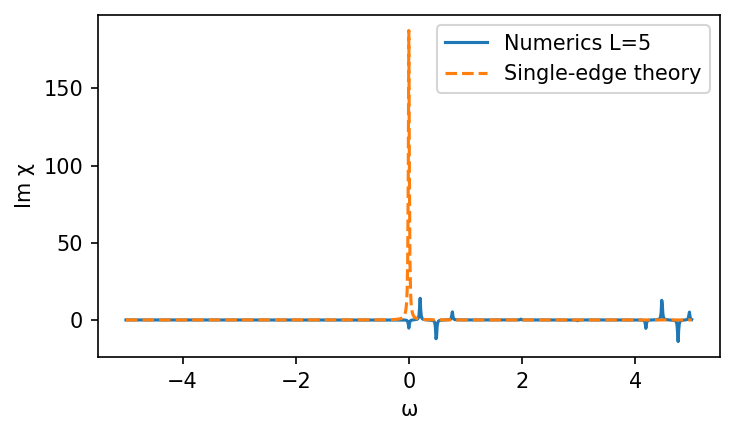

In [650]:
L_plot       = 5
ω            = np.linspace(-5 ,5, 1001)   # zoom around ω = 0
M_num, Imχ_n = compute_M_and_ImChi(L_plot, ω)

delta  = omega_c - omega_q
lam    = delta / (4*g)
M_theo = 1 - lam**2                          # analytic edge weight
Imχ_th = (2*M_theo/gamma) * (gamma**2 / (ω**2 + gamma**2))

plt.figure(figsize=(5,3), dpi=150)
plt.plot(ω, Imχ_n, label=f'Numerics L={L_plot}')
plt.plot(ω, Imχ_th, '--', label='Single‑edge theory')
plt.xlabel('ω'); plt.ylabel('Im χ')
plt.legend(); plt.tight_layout()


In [627]:
Imχ_n

array([ 0.00015948,  0.00016014,  0.00016082, ..., -0.12368533,
       -0.11395277, -0.10532363])

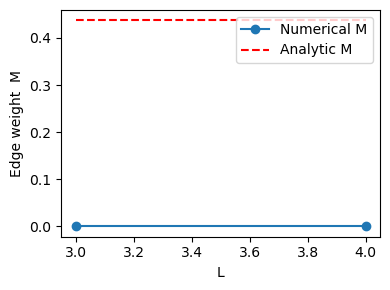

In [516]:
Ls   = np.arange(3, 5)          # L = 3 … 10
M_vs = [compute_M_and_ImChi(L, ω[:1])[0] for L in Ls]   # ω grid not used here

plt.figure(figsize=(4,3))
plt.plot(Ls, M_vs, 'o-', label='Numerical M')
plt.hlines(M_theo, Ls[0], Ls[-1],
           colors='r', linestyles='dashed', label='Analytic M')
plt.xlabel('L'); plt.ylabel('Edge weight  M')
plt.legend(); plt.tight_layout()
